In [143]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [144]:
# Input - Parameter
Pv_kWp = 10
Zinsatz = 0.06
Systemkosten = 800
Betriebskosten = 10 
Lebensdauer = 20


dfEinspeisung = pd.read_csv("PV_Einspeisung.csv")
dfEinspeisung.rename(columns = {0:'Leistung'}, inplace = True)

dfPeise2023 = pd.read_csv("ENTSOE_prices_for_2023_in_ct_per_kWh.csv")
#print(type(dfPeise2023["AT;BE;BG;HR;CZ;DK_1;DK_2;EE;FI;FR;DE_LU;GR;HU;IE_SEM;IT_CALA;IT_CNOR;IT_CSUD;IT_NORD;IT_SARD;IT_SICI;IT_SUD;LV;LT;NL;PL;PT;RO;SK;SI;ES;SE_1;SE_2;SE_3;SE_4"]))

Preise = dfPeise2023["AT;BE;BG;HR;CZ;DK_1;DK_2;EE;FI;FR;DE_LU;GR;HU;IE_SEM;IT_CALA;IT_CNOR;IT_CSUD;IT_NORD;IT_SARD;IT_SICI;IT_SUD;LV;LT;NL;PL;PT;RO;SK;SI;ES;SE_1;SE_2;SE_3;SE_4"].str.split(';', n=0, expand=True)
print(type(Preise[0]))



<class 'pandas.core.series.Series'>


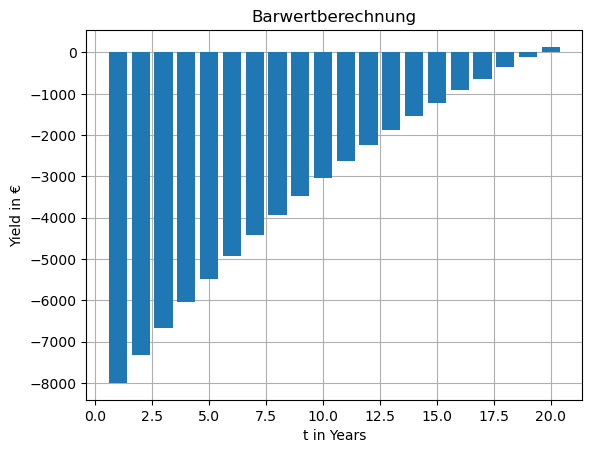

In [145]:
Erlöse = 0
for i in range(8760):
    Erlöse += dfEinspeisung["0"][i] * Pv_kWp /100 * float(Preise[0][i])

NPV = np.zeros(shape=(20,1))
NPV[0][0] = -Pv_kWp*Systemkosten

for i in range(19):
    NPV[i+1][0] = NPV[i][0] + (Erlöse - Betriebskosten)/((1+Zinsatz)**(i+1))

fig, ax = plt.subplots()
ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
ax.set_title("Barwertberechnung")
ax.set_xlabel('t in Years')
ax.set_ylabel('Yield in €')
ax.grid(True, zorder=1)
plt.show()